import necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
import requests
plt.style.use('seaborn')




# Data Preperation and Understanding
Load in data for last three seasons from all of the top leagues. Only count transfers in to avoid double counting. Only count transfers greater than zero pounds, as free transfers are usually players out of contract and don't give us that much information. I also filtered out any transfers that start with 'Loan fee:' because loan fees are much lower than transfers and not the question I am interested in answering. At the end of all that I reset the index.

In [2]:
df = pd.DataFrame()

for year in ['2017','2018','2019']:
    df_eredivisie = pd.read_csv('transfers-master/data/'+year+'/dutch_eredivisie.csv')
    df_championship = pd.read_csv('transfers-master/data/'+year+'/english_championship.csv')
    df_premier_league = pd.read_csv('transfers-master/data/'+year+'/english_premier_league.csv')
    df_ligue_un = pd.read_csv('transfers-master/data/'+year+'/french_ligue_1.csv')
    df_bundesliga = pd.read_csv('transfers-master/data/'+year+'/german_bundesliga_1.csv')
    df_serie_a = pd.read_csv('transfers-master/data/'+year+'/italian_serie_a.csv')
    df_liga_nos = pd.read_csv('transfers-master/data/'+year+'/portugese_liga_nos.csv')
    df_premier_liga = pd.read_csv('transfers-master/data/'+year+'/russian_premier_liga.csv')
    df_la_liga = pd.read_csv('transfers-master/data/'+year+'/spanish_primera_division.csv')
    
    df_transfers = pd.concat([df_eredivisie, df_championship, df_premier_league, df_ligue_un, df_bundesliga,
                             df_serie_a, df_liga_nos, df_premier_liga, df_la_liga])
    
    df_transfers_in = df_transfers[df_transfers.transfer_movement == 'in']
    
    df_transfers_in = df_transfers_in[df_transfers_in.fee_cleaned > 0]
    
    df_transfers_in = df_transfers_in[df_transfers_in.fee.apply(lambda x: not x.startswith('Loan fee:'))]
    
    df = pd.concat([df, df_transfers_in])
    
df.reset_index(drop= True)





,club_name,player_name,age,position,club_involved_name,fee,transfer_movement,fee_cleaned,league_name,year,season
0,Feyenoord Rotterdam,Steven Berghuis,25,Right Winger,Watford,£5.85m,in,5.85,Eredivisie,2017,2017/2018
1,Feyenoord Rotterdam,Ridgeciano Haps,24,Left-Back,AZ Alkmaar,£5.40m,in,5.40,Eredivisie,2017,2017/2018
2,Feyenoord Rotterdam,Jeremiah St. Juste,20,Centre-Back,Heerenveen,£4.32m,in,4.32,Eredivisie,2017,2017/2018
3,Feyenoord Rotterdam,Sofyan Amrabat,20,Central Midfield,FC Utrecht,£3.60m,in,3.60,Eredivisie,2017,2017/2018
4,Feyenoord Rotterdam,Sam Larsson,24,Left Winger,Heerenveen,£3.60m,in,3.60,Eredivisie,2017,2017/2018
...,...,...,...,...,...,...,...,...,...,...,...
2161,Granada CF,Antoñín,19,Centre-Forward,Málaga CF,£1.35m,in,1.35,Primera Division,2019,2019/2020
2162,RCD Mallorca,Ante Budimir,27,Centre-Forward,Crotone,£1.98m,in,1.98,Primera Division,2019,2019/2020
2163,RCD Mallorca,Yannis Salibur,28,Right Winger,Guingamp,£1.80m,in,1.80,Primera Division,2019,2019/2020
2164,RCD Mallorca,Martin Valjent,23,Centre-Back,Chievo Verona,£1.35m,in,1.35,Primera Division,2019,2019/2020


I plotted total transfer spending over the last three years

<AxesSubplot:xlabel='year'>

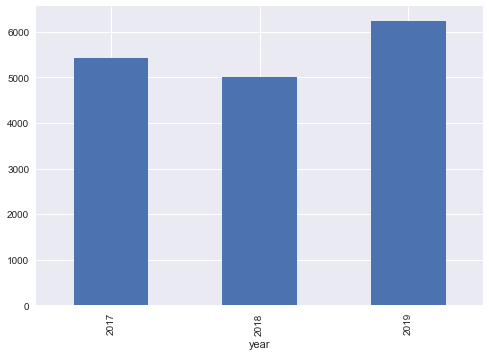

In [55]:
df.groupby('year').fee_cleaned.sum().plot(kind = 'bar')



I plotted the mean transfer value for each year

<AxesSubplot:xlabel='year'>

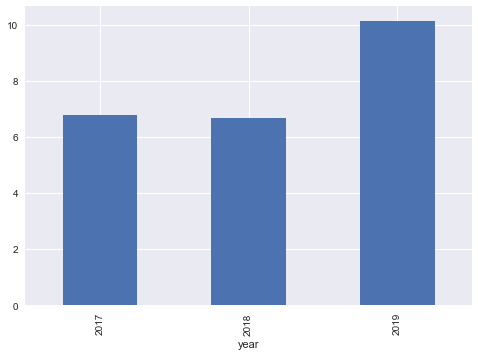

In [56]:
df.groupby('year').fee_cleaned.mean().plot(kind = 'bar')


I plotted the total transfer spending by league

<AxesSubplot:xlabel='league_name'>

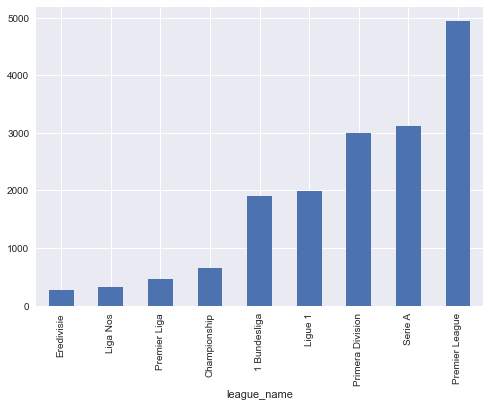

In [57]:
df.groupby('league_name').fee_cleaned.sum().sort_values().plot(kind = 'bar')


I plotted mean transfer value by league

<AxesSubplot:xlabel='league_name'>

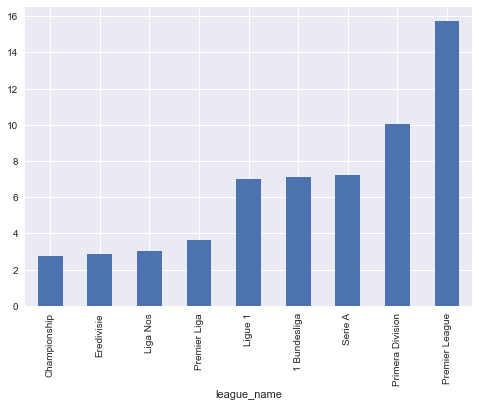

In [58]:
df.groupby('league_name').fee_cleaned.mean().sort_values().plot(kind = 'bar')


I plotted the mean transfer fee as a function of the players age

<AxesSubplot:xlabel='age'>

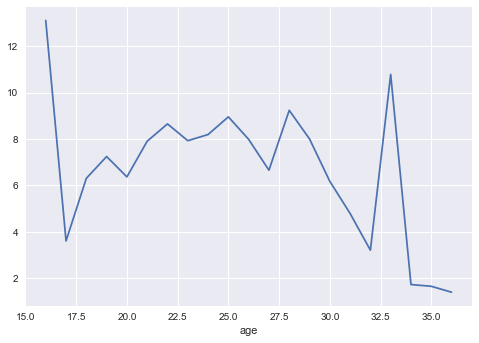

In [59]:
df.groupby('age').fee_cleaned.mean().plot()


Plot mean value by position

<AxesSubplot:xlabel='position'>

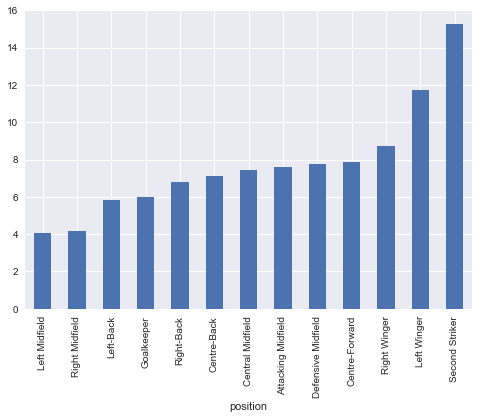

In [60]:
df.groupby('position').fee_cleaned.mean().sort_values().plot(kind = 'bar')


Plot total spending by position

<AxesSubplot:xlabel='position'>

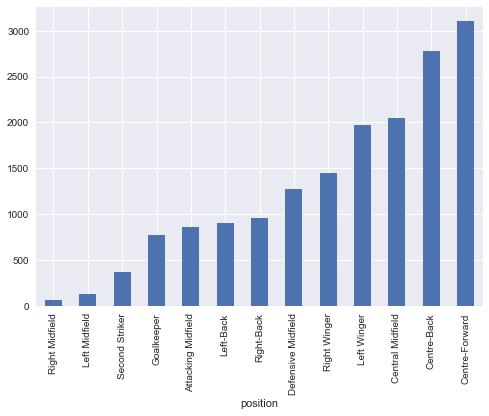

In [61]:
df.groupby('position').fee_cleaned.sum().sort_values().plot(kind = 'bar')


Plot a histogram of all of the fees

<AxesSubplot:xlabel='fee_cleaned'>

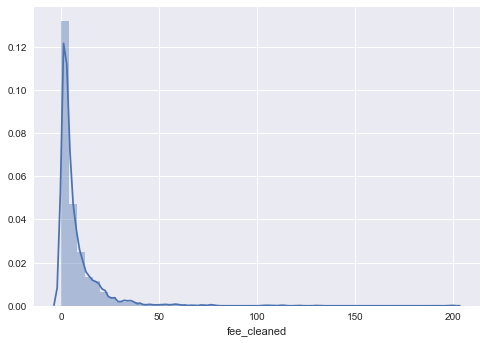

In [62]:
sns.distplot(df.fee_cleaned)


Generate the descriptive statistics of fee, the target variable

In [63]:
df.fee_cleaned.describe()


count    2166.000000
mean        7.698227
std        12.324405
min         0.005000
25%         1.580000
50%         3.600000
75%         9.000000
max       199.800000
Name: fee_cleaned, dtype: float64

Investigatre the largest fee

In [64]:
df[df.fee_cleaned==199.8]


,club_name,player_name,age,position,club_involved_name,fee,transfer_movement,fee_cleaned,league_name,year,season
536,Paris Saint-Germain,Neymar,25,Left Winger,FC Barcelona,£199.80m,in,199.8,Ligue 1,2017,2017/2018


I created a function that took the link to a players fbref page and a year that you are interested in. This function returns the players statistics from that season.

In [97]:
def PlayerScrape(href, year):
    player_table = pd.DataFrame()
    page = requests.get('https://fbref.com/' + href)
    soup = BeautifulSoup(page.content, 'html.parser')
    table = soup.find('tbody')
    if table == None:
        return pd.DataFrame([np.nan])
    rows = table.find_all('tr')
    for row in rows:
        player_table = pd.concat([player_table, pd.DataFrame([[row.find('th').text] + 
                                                               [row.find_all('td')[i].text for i in range(5, len(row)-2)]])])

    player_row =  player_table[player_table[0].apply(lambda x: x.endswith(year))]
    player_row.reset_index(inplace = True, drop = True)
    if not player_row.empty:
        return player_row.iloc[0]
    else:
        return pd.DataFrame([np.nan])

In this cell I comb through the directory of player links on fbref and get links to pages of lists of players.

In [66]:
page = requests.get('https://fbref.com/en/players/')
soup = BeautifulSoup(page.content,'html.parser')
letters = soup.find('ul', class_ = 'page_index')
letters = letters.find_all('a')
links = [letters[i]['href'] for i in range(0,len(letters))]
links

['/en/players/aa/',
 '/en/players/ab/',
 '/en/players/ac/',
 '/en/players/ad/',
 '/en/players/ae/',
 '/en/players/af/',
 '/en/players/ag/',
 '/en/players/ah/',
 '/en/players/ai/',
 '/en/players/aj/',
 '/en/players/ak/',
 '/en/players/al/',
 '/en/players/am/',
 '/en/players/an/',
 '/en/players/ao/',
 '/en/players/ap/',
 '/en/players/aq/',
 '/en/players/ar/',
 '/en/players/as/',
 '/en/players/at/',
 '/en/players/au/',
 '/en/players/av/',
 '/en/players/aw/',
 '/en/players/ax/',
 '/en/players/ay/',
 '/en/players/az/',
 '/en/players/ba/',
 '/en/players/bb/',
 '/en/players/be/',
 '/en/players/bg/',
 '/en/players/bh/',
 '/en/players/bi/',
 '/en/players/bj/',
 '/en/players/bk/',
 '/en/players/bl/',
 '/en/players/bn/',
 '/en/players/bo/',
 '/en/players/br/',
 '/en/players/bs/',
 '/en/players/bv/',
 '/en/players/bw/',
 '/en/players/by/',
 '/en/players/bz/',
 '/en/players/ca/',
 '/en/players/cc/',
 '/en/players/cd/',
 '/en/players/ce/',
 '/en/players/ch/',
 '/en/players/ci/',
 '/en/players/ck/',


I scrape through each of the lists of players generated above and create a list of all players and the link to there fbref page.

In [15]:
#Don't run again
all_player_links = []
for link in links:
    page = requests.get('https://fbref.com' + link)
    soup = BeautifulSoup(page.content, 'html.parser')
    names = soup.find('div', class_ = 'section_content')
    names = names.find_all('a')
    player_links = [[name.text, name['href']] for name in names]
    all_player_links += player_links
all_player_links

[["Ahmad A'adi", '/en/players/9c60f681/Ahmad-Aadi'],
 ['Jamal Aabbou', '/en/players/ad713dff/Jamal-Aabbou'],
 ['Kim Aabech', '/en/players/c48b5529/Kim-Aabech'],
 ['Kamilla Aabel', '/en/players/d7ed844d/Kamilla-Aabel'],
 ['Rayane Aabid', '/en/players/13792bac/Rayane-Aabid'],
 ['Abdelilah Aabiza', '/en/players/191084d1/Abdelilah-Aabiza'],
 ['Hicham Aâboubou', '/en/players/cbe904fa/Hicham-Aaboubou'],
 ['Abubaker Aadem', '/en/players/12648b72/Abubaker-Aadem'],
 ['Gerard Aafjes', '/en/players/84129d72/Gerard-Aafjes'],
 ['Anna Aahjem', '/en/players/8f5fa9e1/Anna-Aahjem'],
 ['Faouzi Aaish', '/en/players/f05ca35b/Faouzi-Aaish'],
 ['Abdelkader Aajji', '/en/players/0ade93c3/Abdelkader-Aajji'],
 ['Mohamed Aakib', '/en/players/9a5b8092/Mohamed-Aakib'],
 ['Andreas Aalbu', '/en/players/4fe6659a/Andreas-Aalbu'],
 ['Levi Aalders', '/en/players/34793b4e/Levi-Aalders'],
 ['Redouan Aalhoul', '/en/players/db4c2506/Redouan-Aalhoul'],
 ['Henri Aalto', '/en/players/690acb29/Henri-Aalto'],
 ['Iiro Aalto', '/e

I drop duplicates on my list of player names, to ensure I am matching the right transfer to the right player. For example there are two players named Moussa Dembele and I want to ensure that they are not confused in my analysis. I then perform an inner merge on the players name with my list of players and my list of transfers on player_name. I perform an inner merge so that I only have players who are on fbref and only have players who I have transfer data for

In [67]:
df_players = pd.DataFrame(all_player_links, columns = ['player_name', 'links'])
df_players.drop_duplicates(subset= 'player_name', keep = False, inplace = True)
df = df.merge(df_players, how = 'inner', left_on= 'player_name', right_on = 'player_name')


I investigated how many players were dropped after dropping duplicates and what my dataframe looked like after the merge

In [68]:
len(all_player_links)

155571

In [69]:
len(df_players)

143319

In [70]:
df


,club_name,player_name,age,position,club_involved_name,fee,transfer_movement,fee_cleaned,league_name,year,season,links
0,Feyenoord Rotterdam,Steven Berghuis,25,Right Winger,Watford,£5.85m,in,5.85,Eredivisie,2017,2017/2018,/en/players/713c144a/Steven-Berghuis
1,Feyenoord Rotterdam,Ridgeciano Haps,24,Left-Back,AZ Alkmaar,£5.40m,in,5.40,Eredivisie,2017,2017/2018,/en/players/c8d7131c/Ridgeciano-Haps
2,Feyenoord Rotterdam,Sofyan Amrabat,20,Central Midfield,FC Utrecht,£3.60m,in,3.60,Eredivisie,2017,2017/2018,/en/players/5a2cb25d/Sofyan-Amrabat
3,ACF Fiorentina,Sofyan Amrabat,23,Central Midfield,Hellas Verona,£9.49m,in,9.49,Serie A,2019,2019/2020,/en/players/5a2cb25d/Sofyan-Amrabat
4,Hellas Verona,Sofyan Amrabat,23,Central Midfield,Club Brugge,£3.15m,in,3.15,Serie A,2019,2019/2020,/en/players/5a2cb25d/Sofyan-Amrabat
...,...,...,...,...,...,...,...,...,...,...,...,...
1604,CA Osasuna,Marc Cardona,23,Centre-Forward,FC Barcelona,£2.25m,in,2.25,Primera Division,2019,2019/2020,/en/players/b92b456a/Marc-Cardona
1605,CA Osasuna,Robert Ibáñez,26,Right Winger,Getafe,£1.80m,in,1.80,Primera Division,2019,2019/2020,/en/players/c7429db3/Robert-Ibanez
1606,Granada CF,Darwin Machís,26,Left Winger,Udinese Calcio,£2.70m,in,2.70,Primera Division,2019,2019/2020,/en/players/ed6ea4d9/Darwin-Machis
1607,Granada CF,Domingos Duarte,24,Centre-Back,Sporting CP,£2.70m,in,2.70,Primera Division,2019,2019/2020,/en/players/93090f69/Domingos-Duarte


In [71]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1609 entries, 0 to 1608
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   club_name           1609 non-null   object 
 1   player_name         1609 non-null   object 
 2   age                 1609 non-null   int64  
 3   position            1609 non-null   object 
 4   club_involved_name  1609 non-null   object 
 5   fee                 1609 non-null   object 
 6   transfer_movement   1609 non-null   object 
 7   fee_cleaned         1609 non-null   float64
 8   league_name         1609 non-null   object 
 9   year                1609 non-null   int64  
 10  season              1609 non-null   object 
 11  links               1609 non-null   object 
dtypes: float64(1), int64(2), object(9)
memory usage: 163.4+ KB


This cell scrapes player data for every player in my new dataframe df. It takes a very long time to run

In [98]:
#Really don't run
df_to_add = pd.DataFrame()
for row in range(0, len(df)):
    new_row = PlayerScrape(df.iloc[row]['links'], str(df.iloc[row]['year']))
    df_to_add = df_to_add.append(new_row, ignore_index = True)
df_to_add


,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,2016-2017,30,25,"2,100",7,5,0,0,4,0,...,0.30,0.51,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2016-2017,30,30,"2,639",0,2,0,0,7,1,...,0.00,0.07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2016-2017,31,29,"2,570",0,5,0,0,5,0,...,0.00,0.18,,,,,,,,
3,2018-2019,24,10,"1,156",1,0,0,0,4,0,...,0.08,0.08,,,,,,,,
4,2018-2019,24,10,"1,156",1,0,0,0,4,0,...,0.08,0.08,,,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1604,2018-2019,17,6,604,3,1,0,0,1,0,...,0.45,0.60,2.7,2.7,0.6,0.41,0.10,0.50,0.41,0.50
1605,2018-2019,7,0,76,0,0,0,0,1,0,...,0.00,0.00,0.2,0.2,0.0,0.25,0.00,0.25,0.25,0.25
1606,2018-2019,13,4,463,0,1,0,0,2,0,...,0.00,0.19,1.3,1.3,0.6,0.26,0.12,0.38,0.26,0.38
1607,2018-2019,39,39,"3,478",4,0,0,0,13,0,...,0.10,0.10,,,,,,,,


In [99]:
df_to_add.columns = ['Season', 'Matches', 'Starts', 'Minutes', 'Goals', 'Assists', 'Penalty_Goals','Penalty_Attempts',
                     'Yellow_Cards', 'Red_Cards', 'Goals/90', 'Assists/90', 'Goals+Assists/90', 'Goals-PKs/90',
                     'Goals+Assists-PKs/90', 'xG', 'npxG', 'xA', 'xG/90','xA/90', 'xG+xA/90', 'npxG/90', 'npxG+xA/90']
df_to_add = df_to_add.reset_index(drop = True)


In [101]:
df = df.join(df_to_add)


In [103]:
df.to_csv('database.csv')


At the end I turned all the data into a csv to use in modeling